In [78]:
### Evaluación de scNovel con conjunto de datos de células mononucleares de sangre periférica (PBMC3k)
import scanpy as sc
import scNovel as sr
import pandas as pd
import numpy as np
import copy
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import os



### =============================================
### Carga de datos y preprocesamiento 
### =============================================

In [121]:
# Fijamos una semilla aleatoria para asegurar la reproducibilidad de los resultados en todo el análisis
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Cargamos el conjunto de datos PBMC3k directamente desde Scanpy
# Este dataset contiene datos de expresión génica de aproximadamente 3.000 células sanguíneas mononucleares periféricas (PBMCs) de un donante sano
adata = sc.datasets.pbmc3k()

#Normalizamos los datos para que cada célula tenga el mismo total de cuentas (10.000), corrigiendo diferencias en la profundidad de secuenciación
sc.pp.normalize_total(adata, target_sum=1e4)
# Aplicamos una transformación logarítmica (log(x+1)) para estabilizar la varianza y reducir la dispersión de los datos
sc.pp.log1p(adata)

# Realizamos una reducción de dimensionalidad mediante PCA conservando las 50 primeras componentes principales,
# Esto facilita la agrupación y visualización de las células en el siguiente paso
sc.tl.pca(adata, n_comps=50)

# Calculamos la matriz de vecinos más cercanos, utilizando 10 vecinos y las 50 componentes principales obtenidas por PCA.
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

# Aplicamos el algoritmo Leiden para identificar grupos de células similares (clustering) de forma no supervisada.
# El parámetro random_state anteriormente creado garantiza la reproducibilidad del agrupamiento
sc.tl.leiden(adata, random_state=RANDOM_STATE)

# Extraemos las etiquetas de clúster generadas por Leiden y las almacenamos como una categoría en el objeto AnnData.
# Estas etiquetas se utilizarán posteriormente como referencia para la identificación de subpoblaciones celulares
label = adata.obs['leiden'].rename('Label').astype('category')


In [139]:
print (adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'leiden', 'ood_score'
    var: 'gene_ids'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


### =====================================================
### Construcción del dataset y evaluación con scNovel
### =====================================================

In [124]:

def build_ood_dataset(adata, label, drop_number=1):
    label_df = label.to_frame()
    
    # Identificar la clase más rara
    counts = label.value_counts()
    rare_class = counts.idxmin()
    print(f"Clase rara identificada: {rare_class} (n={counts.min()} células)")
    
    # Separar OOD (clase rara) vs in-distribution
    ood_mask = (label == rare_class)
    adata_id = adata[~ood_mask]
    label_id = label[~ood_mask]
    adata_ood = adata[ood_mask]
    
    # División estratificada en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        adata_id, label_id, test_size=0.2, random_state=RANDOM_STATE, stratify=label_id
    )
    
    return X_train, X_test, y_train, y_test, adata_ood


X_train, X_test, y_train, y_test, X_ood = build_ood_dataset(adata, label)

# Preparar test_all (concat test in-distribution + OOD)
test_all = X_test.concatenate(X_ood)
true_label = np.concatenate([
    np.zeros(len(X_test)),    # 0 para in-distribution (asumiremos que son normales)
    np.ones(len(X_ood))       # 1 para OOD
])

# Conversión a DataFrames (requerido por scRare)
X_train_df = pd.DataFrame(
    X_train.X.toarray() if hasattr(X_train.X, "toarray") else X_train.X,
    index=X_train.obs_names,
    columns=X_train.var_names
)

test_all_df = pd.DataFrame(
    test_all.X.toarray() if hasattr(test_all.X, "toarray") else test_all.X,
    index=test_all.obs_names,
    columns=test_all.var_names
)

# Preparar etiquetas de entrenamiento (convertir a numéricas)
y_train_df = y_train.cat.codes.to_frame(name='Label')

# Llamada a scRare (configuración similar a Darmanis)
test_score = sr.scRare(
    test_all_df, 
    X_train_df, 
    y_train_df, 
    processing_unit='gpu', 
    score_function='sim', 
    iteration_number=50  # Aumentado para mejor detección OOD
)

Clase rara identificada: 11 (n=11 células)


C:\Users\34635\AppData\Local\Temp\ipykernel_13764\1054309422.py:26: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  test_all = X_test.concatenate(X_ood)


--------Start annotating----------
No GPUs are available on your server.
Computational unit be used is: cpu
Finish 50.0/50

--------Annotation Finished----------


En este análisis, seguimos un enfoque análogo al aplicado en el dataset de Darmanis. 
1) Primero, identificamos el clúster menos representado en el conjunto PBMC3k (usando las etiquetas generadas por Leiden) y lo consideramos como clase rara o out-of-distribution (OOD). Las células de este clúster se separan del resto, que se consideran in-distribution (ID).
2) A continuación, dividimos las células ID en conjuntos de entrenamiento y test, y finalmente concatenamos el test ID con el OOD para evaluar la capacidad del modelo de detectar células raras. Los datos se convierten a DataFrames para su uso en scRare, y las etiquetas de entrenamiento se transforman a formato numérico. Este procedimiento permite comparar la detección de células raras en diferentes datasets bajo un mismo marco metodológico.

### ====================================================
### Evaluación del rendimiento con AUROC
### ====================================================

In [127]:

auroc = roc_auc_score(true_label, test_score)
print(f"\nResultado OOD Detection:")
print(f"AUROC: {auroc:.4f}")
print(f"Distribución de scores:")
print(pd.DataFrame(test_score, columns=['Score']).describe())




Resultado OOD Detection:
AUROC: 0.7198
Distribución de scores:
            Score
count  549.000000
mean     0.384287
std      0.083482
min      0.210726
25%      0.328285
50%      0.372702
75%      0.424702
max      0.777969


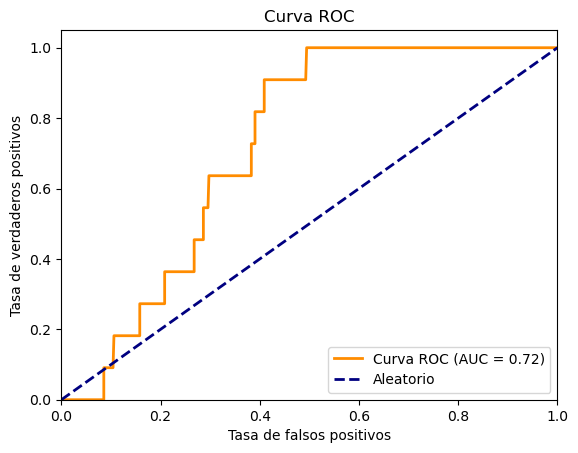

In [130]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcula las tasas de falsos positivos y verdaderos positivos
fpr, tpr, thresholds = roc_curve(true_label, test_score)

# Calcula el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Dibuja la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

El valor del AUROC puede cambiar un poco cada vez que ejecutamos el código.
Esto pasa porque hay partes del proceso que tienen algo de aleatoriedad, como la selección de los datos de entrenamiento y test, o el propio algoritmo de clustering. Por eso, aunque el modelo y los datos sean los mismos, el AUROC no siempre va a salir igual.
Es normal ver pequeñas diferencias entre ejecuciones, sobre todo si el conjunto de datos es pequeño o hay clases poco representadas. 

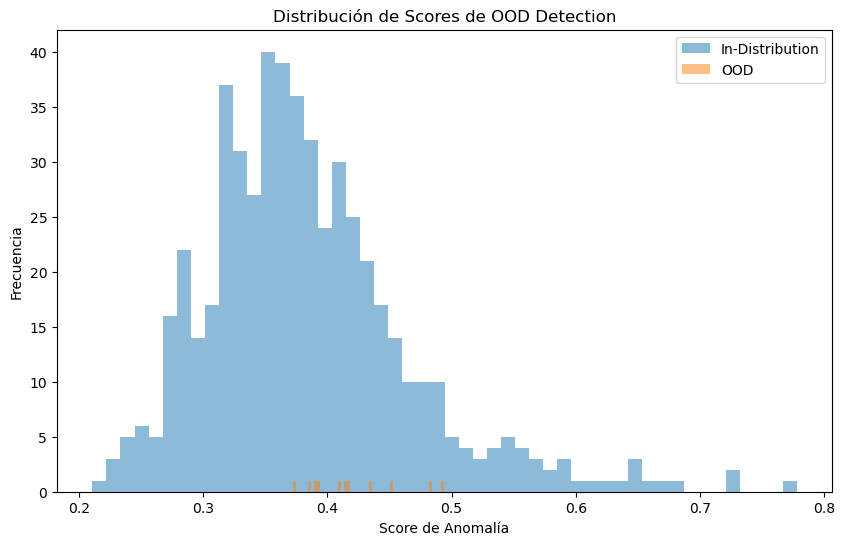

In [132]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(test_score[true_label == 0], bins=50, alpha=0.5, label='In-Distribution')
plt.hist(test_score[true_label == 1], bins=50, alpha=0.5, label='OOD')
plt.xlabel('Score de Anomalía')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Distribución de Scores de OOD Detection')
plt.show()

In [134]:
print(test_score[:10])

[0.4284772  0.40960085 0.40625232 0.46590167 0.5237454  0.40474224
 0.31974933 0.31837052 0.30802956 0.38934568]


### ===============================================
### Visualización 
### ===============================================


Generando visualización de validación...


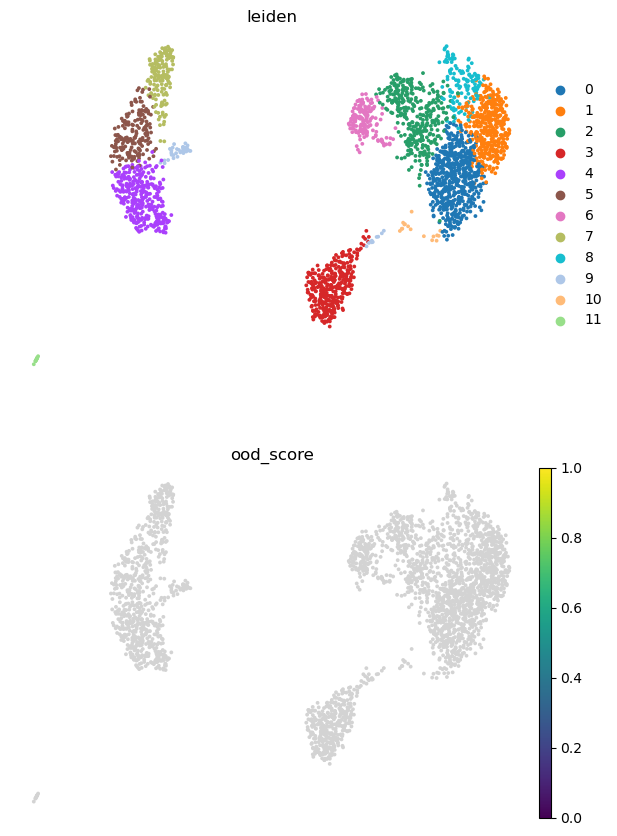

In [137]:

print("\nGenerando visualización de validación...")
sc.tl.umap(adata, random_state=RANDOM_STATE)

# Creamos Series con los scores manteniendo los índices correctos
scores_series = pd.Series(test_score, index=test_all.obs_names.str.split('-').str[0])

# Asignamos scores al objeto adata original
adata.obs['ood_score'] = scores_series

# Visualización de los cliuster
sc.pl.umap(
    adata,
    color=['leiden', 'ood_score'],
    frameon=False,
    ncols=1,
    size=30,
    color_map='viridis',
    vmin=0,
    vmax=1
)

Observamos que el algoritmo Leiden crea 11 clústeres distintos a partir de los datos de expresión génica. El clúster etiquetado como "11" es el que contiene menos células de todos, lo que sugiere que agrupa una población rara o potencialmente novedosa dentro del conjunto de datos. 
Este tipo de agrupamiento es habitual en scRNA-seq: los algoritmos de clustering como Leiden tienden a separar las células según similitudes en sus perfiles de expresión, y los clústeres pequeños suelen corresponder a subpoblaciones raras o a tipos celulares poco representados

In [5]:
import numpy as np

aurocs = np.array([0.7849, 0.6061, 0.6989])
media = np.mean(aurocs)
de = np.std(aurocs, ddof=1)  # ddof=1 para muestra (no población)

print(f"Media AUROC: {media:.4f} ± {de:.4f} (DE)")

Media AUROC: 0.6966 ± 0.0894 (DE)
